<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
import lightgbm as lgb
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
print(data.head(5))
data.info()
print(data.isnull().sum())


                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB
num_orders    0
dtype: int64


Загрузили данные, колонку со временем сделали индексом, пропусков в данных нет, проверим на выбросы.

Text(0, 0.5, 'Количество')

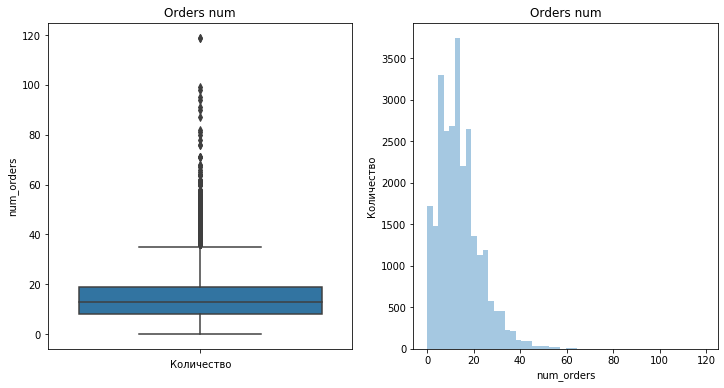

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title('Orders num')
sns.boxplot(y = 'num_orders', data=data, ax = axes[0])
axes[0].set_xlabel('Количество')
     
axes[1].set_title('Orders num')
sns.distplot(data['num_orders'], kde=False, bins=50, ax = axes[1])
axes[1].set_ylabel('Количество')

Будем считать, что выбросов нет. Сделаем ресемплирование данных по одному часу. 

In [4]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


ТАким образом получается 4416 строк с данными за 1 час.

## Анализ

Рассмотрим тренд, выделим сезонность в данных.

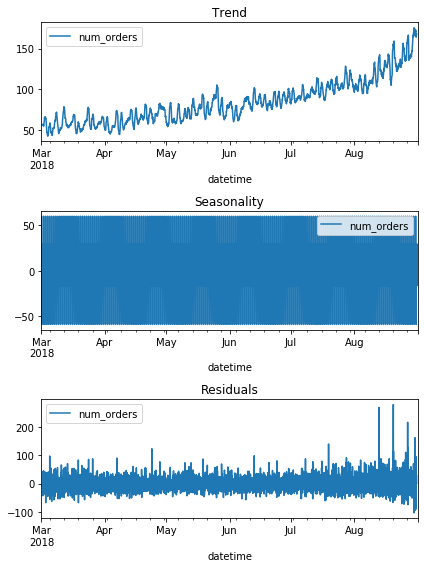

In [5]:
decomposed = seasonal_decompose(data)
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid
plt.figure(figsize=(6, 8))
plt.subplot(311)
trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
residual.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Сезонность скорее всего есть, но не на масштабе месяцев, скорее всего на масштабе суток. Выделим сезонность на масштабе 3 суток.

Text(0.5, 1.0, 'Seasonality')

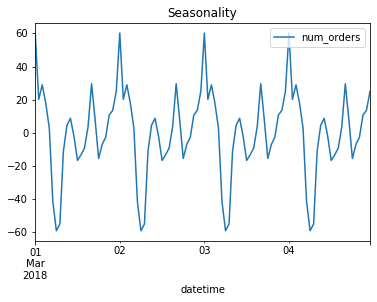

In [6]:
decomposed.seasonal['2018-03-01':'2018-03-04'].plot(ax=plt.gca())
plt.title('Seasonality')

Рассмотрим подробнее сутки. Далее временной ряд опишем стохастическим процессом. Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются.

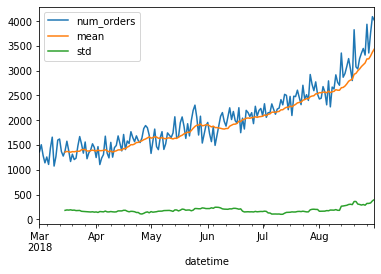

In [7]:
df = data.copy()
df = df['2018-03':'2018-08'].resample('1D').sum()
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot()

Среднее значение меняется - ряд не стационарный, прогнозу не подлежит. Необходимо сделать стационарный, найдем разности значений ряда.

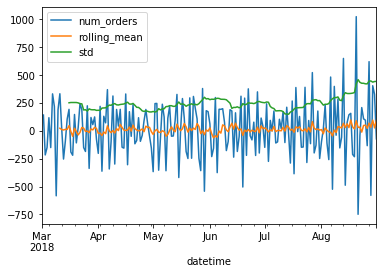

In [8]:

df = data.copy()
df = df['2018-03':'2018-08'].resample('1D').sum()
df = df - df.shift()
df['rolling_mean'] = df['num_orders'].rolling(10).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot()

Ряд стал стационарным - его можно прогнозировать.

## Обучение

In [62]:
data.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,rolling_mean,lag_3
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,93.333333,124.0
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,74.000000,85.0


In [63]:
#  функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [64]:
# применим функцию к таблице, максимальный размер отставания примем равным 2
make_features(data, 2, 3)

In [65]:

# разделим данные на тестовую и тренировочную выборки в соотношении 80:10:10
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)
train = train.dropna()
train_valid = train_valid.dropna()

In [66]:

# выделим признаки и целевой признак
train_y = train['num_orders']
test_y = test['num_orders']
valid_y = valid['num_orders']
train_valid_y = train_valid['num_orders']

train_x = train.drop('num_orders', axis=1)
test_x = test.drop('num_orders', axis=1)
valid_x = valid.drop('num_orders', axis=1)
train_valid_x = train_valid.drop('num_orders', axis=1)

In [67]:
# обучим модель линейной регрессии
model_LR = LinearRegression()
model_LR.fit(train_x, train_y)
pred_valid_LR = model_LR.predict(valid_x)
mean_squared_error(valid_y, pred_valid_LR)**0.5

40.9295373621272

In [68]:
%%time
# обучим основываясь на библиотеке CatBoost
i = 0
result = pd.DataFrame(columns=['iteration','depth', 'learning_rate', 'rMSE'])
for iteration in range(20, 101, 10):
     for depth in range(1, 10, 2): 
        for learning_rate in np.arange(0.1, 1, 0.5):
            model = CatBoostRegressor(loss_function='RMSE', iterations=iteration , depth=depth, learning_rate=learning_rate)
            model.fit(train_x, train_y, verbose=False)
            pred_valid = model.predict(valid_x)
            result.loc[i] = [iteration, depth, learning_rate, mean_squared_error(valid_y, pred_valid)**0.5]
            i += 1
result.sort_values('rMSE').head(5)

CPU times: user 1min 26s, sys: 11.1 s, total: 1min 37s
Wall time: 3min 26s


,iteration,depth,learning_rate,rMSE
33,50.0,3.0,0.6,32.678625
43,60.0,3.0,0.6,32.831698
53,70.0,3.0,0.6,33.005700
86,100.0,7.0,0.1,33.102950
23,40.0,3.0,0.6,33.123873


In [69]:
%%time
# Обучим модель CatBoost с параметрами  по умолчанию
model_cb = CatBoostRegressor(loss_function='RMSE')
model_cb.fit(train_x, train_y, verbose=False)
pred_valid_CB = model_cb.predict(valid_x)
mean_squared_error(valid_y, pred_valid_CB)**0.5

CPU times: user 16.7 s, sys: 2.76 s, total: 19.5 s
Wall time: 20.7 s


32.83715413987433

Проведя обучение моделей и проверив на валидационой выборке можно отобрать для тестирования как показавшию наибольшее качество модель CatBoost со значениями по умолчанию, модель случайного леса с несколько более худшим результатом и параметрами количеством деревьев равным 100 и глубиной 9. На третей позиции модель линейной регрессии. При этом все модели на валидационой выборке показали результат rMSE менее 48

## Тестирование


Проведем тестирование на отобранных моделях. Обучим на датасете train+valid

In [70]:
# обучим модель линейной регрессии
model_LR = LinearRegression()
model_LR.fit(train_valid_x, train_valid_y)
pred_test_LR = model_LR.predict(test_x)

In [71]:
# обучим модель на оптимальных гиперпараметрах
model_RFR = RandomForestRegressor(random_state=123, n_estimators=100, max_depth=9)
model_RFR.fit(train_valid_x, train_valid_y)
pred_test_RFR = model_RFR.predict(test_x)

In [72]:
%%time
# Обучим модель с параметрами  по умолчанию
model_cb = CatBoostRegressor(loss_function='RMSE')
model_cb.fit(train_valid_x, train_valid_y, verbose=False)
pred_test_CB = model_cb.predict(test_x)

CPU times: user 15.7 s, sys: 2.29 s, total: 18 s
Wall time: 19.2 s


In [73]:
print("rMSE тестовой выборки на линейной регрессии: ", mean_squared_error(test_y, pred_test_LR)**0.5)
print("rMSE тестовой выборки на случайном лесе: ", mean_squared_error(test_y, pred_test_RFR)**0.5)
print("rMSE тестовой выборки на CatBoost: ", mean_squared_error(test_y, pred_test_CB)**0.5)

rMSE тестовой выборки на линейной регрессии:  52.42749680095463
rMSE тестовой выборки на случайном лесе:  50.76156158836391
rMSE тестовой выборки на CatBoost:  45.17823789997516


Наилучший результат на тестовой выборке показала модель обученная на CatBoost с результатом rMSE равным 45.17. Модель превысила пороговое значение 48 случайного леса имеет результат rMSE равным 50.76. А модель линейной регресии тоже превысила установленое ограничение  и имеет результат rMSE равным 52.42